In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import cv2
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import Tree2D, Tree3Dv2, Tree3D
from tree_segmentation.render import choose_best_views, random_camera_position, render_mesh
from paper.paper_util import get_2d_tree_from_3d
from evaluation.eval_Replica import load_mesh_and_gt, load_images
import open3d as o3d


/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.0.1+cu117


In [3]:
data_root = Path('~/data/Replica').expanduser()
scene = 'office_4'
data_dir = data_root.joinpath(scene)
print('data direcotry:', data_dir)
mesh_path = data_dir.joinpath('simplify.ply')
cache_dir = Path(f'./results/Replica/{scene}')
# cache_dir.mkdir(exist_ok=True)
print('cache dir:', os.listdir(cache_dir))

data direcotry: /home/wan/data/Replica/office_4
cache dir: ['n10000.tree3dv2', 'gt.tree3dv2', 'images']


In [4]:
mesh, gt = load_mesh_and_gt(data_dir, cache_dir)
mesh = mesh.to(device).unit_size()
roate_angle = {
    'office_0': 5,
    'office_1': 34,
    'office_2': 66.5,
    'office_3': 52,
    'office_4': 7,
    'room_0': 0,
    'room_1': 26,
    'room_2': -10,
}[scene]
mesh.v_pos = ops_3d.xfm(mesh.v_pos, ops_3d.rotate_z(-math.radians(roate_angle), device))[:, :3].contiguous()
mesh.v_pos = mesh.v_pos[:, (0, 2, 1)].contiguous()
mesh = mesh.unit_size()
print(mesh)

[Tree3D] load results from: results/Replica/office_4/gt.tree3dv2
Load GT from results/Replica/office_4/gt.tree3dv2
Mesh(vertices=249994, faces=499932, clr, nrm)


In [5]:
eye = torch.tensor([0, 0, 0.], device=device)
n = 25 * 1
phis = torch.linspace(0, 2 * torch.pi,n).to(device)
theta = torch.full((n ,),  math.radians(90), device=device)
at = ops_3d.coord_spherical_to(torch.ones(n, device=device), theta, phis)
print(at.shape, eye.shape)
Tw2v = ops_3d.look_at(eye[None].expand_as(at), at)
print(Tw2v.shape)


torch.Size([25, 3]) torch.Size([3])
torch.Size([25, 4, 4])


[F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4], F32Tensor[1, 1024, 1024, 4]], [IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1, 1024, 1024], IntTensor[1,

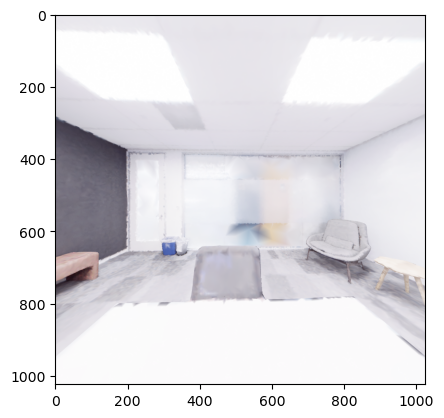

In [6]:
images, tri_ids = [], []
num_split = 1
for s in range(0, n, num_split):
    image, tri_id = render_mesh(glctx, mesh, Tw2v[s:s+num_split], fovy=math.radians(120))
    images.append(image.cpu())
    tri_ids.append(tri_id.cpu())
print(utils.show_shape(images, tri_ids))
images = torch.cat(images, dim=0)
tri_ids = torch.cat(tri_ids, dim=0)
print(utils.show_shape(images, tri_ids))
plt.imshow(utils.as_np_image(images[0]))


In [11]:
utils.save_gif(Path('office_0.gif'), images.cpu().mul(255).to(torch.uint8).numpy(), fps=25)

In [ ]:
tree3d = Tree3Dv2(mesh, device=device)
tree3d.load(cache_dir.joinpath('n10000.tree3dv2'))
print(tree3d.cnt)

In [ ]:
gt.to(device)
metric = ts.TreeSegmentMetric()
metric.update(tree3d, gt)
for k, v in metric.summarize().items():
    print(k, v)
# office_1 : 0.1251517567576962  0.27585703134536743
# office_2 : 0.1387479216551128  0.2234853208065033
# office_3 : 0.10399148706269543  0.2038615643978119
# office_4 : 0.149106233955931  0.3036523163318634

In [ ]:
show_index = np.random.randint(100)
print('index:', show_index)
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])

In [ ]:
def save_results(index, save_dir:Path=None, alpha=0.5):
    image = images[index, :, :, :3]
    if save_dir is not None:
        save_dir.mkdir(exist_ok=True, parents=True)
        utils.save_image(save_dir.joinpath(f'view_{index}.png'), image)
    plt.imshow(image.cpu().numpy())
    plt.show()
    # return
  
    tree2d = tree3d.get_2d_tree(tri_ids[index].to(device))    
    print(utils.show_shape(image, tree2d.masks))
    image = image.cpu().numpy()
    for level, nodes in enumerate( tree2d.get_levels()):
        if level == 0:
            continue
        image_l = image.copy()
        colored_mask = ts.get_colored_masks(tree2d.masks[nodes-1])
        image_l = cv2.addWeighted(image_l, alpha, colored_mask, 1-alpha, 0)
        for x in nodes:
            p = tree2d.parent[x].item() - 1
            x = x.item() - 1
            image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[x], color=(0, 0, 0), kernel_size=5)
            # image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[p],color=(0, 0, 0),  kernel_size=9)
        if save_dir is not None:
            utils.save_image(save_dir.joinpath(f'view_{index}_l{level}.png'), image_l)
        plt.imshow(image_l)
        plt.show()


# for i in range(22):
save_results(32, cache_dir.joinpath('08_19'))
# save_results(9)